## Reading all masks from the folders and producing one single mask file

In [1]:
import cv2
import glob
import numpy as np
DATA_DIR = "./input"
split = 'names'

from __future__ import print_function, division
import os
import pandas as pd
import skimage
import random
import skimage.io
from skimage import transform
from skimage.viewer import ImageViewer
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import glob


def read_from_file(list_file, comment='#'):
    with open(list_file) as f:
        lines  = f.readlines()
    strings=[]
    for line in lines:
        s = line.split(comment, 1)[0].strip()
        if s != '':
            strings.append(s)
    return strings
        
def combining_masks():
    ids = read_from_file(DATA_DIR + '/names/' + split, comment='#')
    num_ids = len(ids)
    for i in range(num_ids):
        id = ids[i]
        image_files = glob.glob(DATA_DIR + '/' + id + '/images/*.png')
        image_file=image_files[0]
        image = cv2.imread(image_file,cv2.IMREAD_COLOR)
        H,W,C = image.shape
        one_mask = np.zeros((H,W), dtype=bool)
        mask_files =glob.glob(DATA_DIR + '/' + id + '/masks/*.png')
        for mask_file in mask_files:
            mask = cv2.imread(mask_file,cv2.IMREAD_GRAYSCALE)
            one_mask = one_mask |(mask>128)
        one_mask = (one_mask*255).astype(np.uint8)
        cv2.imwrite(DATA_DIR + '/' + id + '/mask.png', one_mask)


/anaconda/envs/py35/lib/python3.5/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [ ]:
combining_masks()

### Splitting dataset ids on training and validation

In [2]:
from sklearn.model_selection import train_test_split
ids = read_from_file(DATA_DIR + '/names/' + split, comment='#')
num_ids = len(ids)
ids_train, ids_test = train_test_split(ids, test_size=0.20, random_state=42)

## All random data augmentations in one function

In [3]:
def data_aug(image,label,angel=5,resize_rate=0.3, output_size=256):

    flip = random.randint(0, 1)
    size = image.shape[0]
    sh = random.random()/2-0.25
    rotate_angel = random.random()/180*np.pi*angel
    sigma = random.uniform(0,0.6)
    scaling = random.uniform(0.1,1)
    
    # Rescale
    transform.rescale(image, scaling, mode='reflect')
    transform.rescale(label, scaling, mode='reflect')   
        
    # Create affine transform
    afine_tf = transform.AffineTransform(shear=sh,rotation=rotate_angel)
    
    # Apply transform to image data|
    image = transform.warp(image, inverse_map=afine_tf,mode='edge')
    label = transform.warp(label, inverse_map=afine_tf,mode='edge')
    
    # Ramdomly flip frame
    if flip:
        image = image[:,::-1,:]
        label = label[:,::-1]
        
    #Shuffle the RGB channels to get color invariance
    p = [0,1,2]
    random.shuffle(p)
    image[:,:,:] = image[:,:,p]    
    #Change exposure/intensity randomly:
    imageAlp = image[:,:,2]  
    imageRest = image[:,:,0:3]
    if random.randint(0,1)==0:
        #use clahe
        image = exposure.equalize_adapthist(image)    
    if random.randint(0,1)==0:
        image = exposure.rescale_intensity(image,(0,random.uniform(0.5,1)))        
    
    #Rotate the image
    rotate = random.randint(0,3)
    image = transform.rotate(image, rotate*np.pi/2, mode='reflect')
    label = transform.rotate(label, rotate*np.pi/2, mode='reflect')

    #Corrupt data a little
    if sigma > 0:
        image = np.minimum(np.maximum(0.0,image + np.random.normal(0, sigma, image.shape)/255.0),255.0)
    
    
    # Randomly cropping image frame
    rsize = random.randint(np.floor(resize_rate*size),size)
    w_s = random.randint(0,size - rsize)
    h_s = random.randint(0,size - rsize)
    image = image[w_s:w_s+size,h_s:h_s+size,:]
    label = label[w_s:w_s+size,h_s:h_s+size]
    
    
    #Now we resize the image
    image = transform.resize(image, (output_size, output_size))
    label = transform.resize(label, (output_size, output_size))
    image = image.transpose(2, 0, 1)
    #label  = cv2.threshold(label, 128, 255, cv2.THRESH_BINARY)[1]
    label[label > 0.] = 1
    return image.astype(float), label.astype(float)


## Creating Dataset to use it in DataLoader

In [4]:
from torch.utils.data.dataset import Dataset

class ImageMaskDataset(Dataset):

    def __init__(self, ids, mode='train', transform= None):
        super(ImageMaskDataset, self).__init__()
        self.split = split
        self.mode = mode
        self.transform = transform
        self.ids = ids

    def __getitem__(self, index):
        id   = self.ids[index]
        name = id.split('/')[-1]
        image_file = DATA_DIR + '/' + id + '/images/' + name +'.png'
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)

        if self.mode in ['train']:
            mask_file =  DATA_DIR + '/' + id + '/mask.png'
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            return self.transform(image,mask)

        if self.mode in ['test']:
            return self.transform(image)

    def __len__(self):
        return len(self.ids)

#### Function for image visualisation

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import *
def image_show(name, image, resize=1):
    H,W = image.shape[0:2]
    cv2.namedWindow(name, cv2.WINDOW_NORMAL)
    cv2.imshow(name, image.astype(np.uint8))
    cv2.resizeWindow(name, round(resize*W), round(resize*H))

#### Simple data augmentation for testing

In [6]:
WIDTH = 256
HIGHT =256
def simple_augment(image,mask, output_size=256):
    #Now we resize the image
    image = transform.resize(image, (output_size, output_size))
    label = transform.resize(mask, (output_size, output_size))
    image = image.transpose(2, 0, 1)
    #label  = cv2.threshold(label, 128, 255, cv2.THRESH_BINARY)[1]
    label[label > 0.] = 1
    return image.astype(float), label.astype(float)

dataset = ImageMaskDataset(
        ids_train, mode='train', transform = data_aug
    )
sampler = RandomSampler(dataset)

In [7]:
dataset[1][0]

/anaconda/envs/py35/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/anaconda/envs/py35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


array([[[0.01700473, 0.0154302 , 0.01302638, ..., 0.03025679,
         0.02979247, 0.02471269],
        [0.01999913, 0.01929537, 0.0167734 , ..., 0.02797773,
         0.02771597, 0.0231318 ],
        [0.01942247, 0.02044485, 0.01929909, ..., 0.02688508,
         0.02724264, 0.02330324],
        ...,
        [0.02999143, 0.04398554, 0.05008909, ..., 0.07544445,
         0.07446876, 0.06241217],
        [0.02655623, 0.0375952 , 0.04357255, ..., 0.06499667,
         0.06398923, 0.05322307],
        [0.02168018, 0.02727102, 0.03155581, ..., 0.0487839 ,
         0.04816464, 0.03992211]],

       [[0.01642394, 0.01545449, 0.01381464, ..., 0.03019636,
         0.03046128, 0.0263529 ],
        [0.02041322, 0.02043863, 0.01811909, ..., 0.02807585,
         0.02847166, 0.02457555],
        [0.01978052, 0.02183509, 0.02118558, ..., 0.0272203 ,
         0.02754983, 0.02348689],
        ...,
        [0.03187158, 0.04495272, 0.05041458, ..., 0.07514896,
         0.07435624, 0.06243281],
        [0.0

## `UNet` class is based on https://arxiv.org/abs/1505.04597

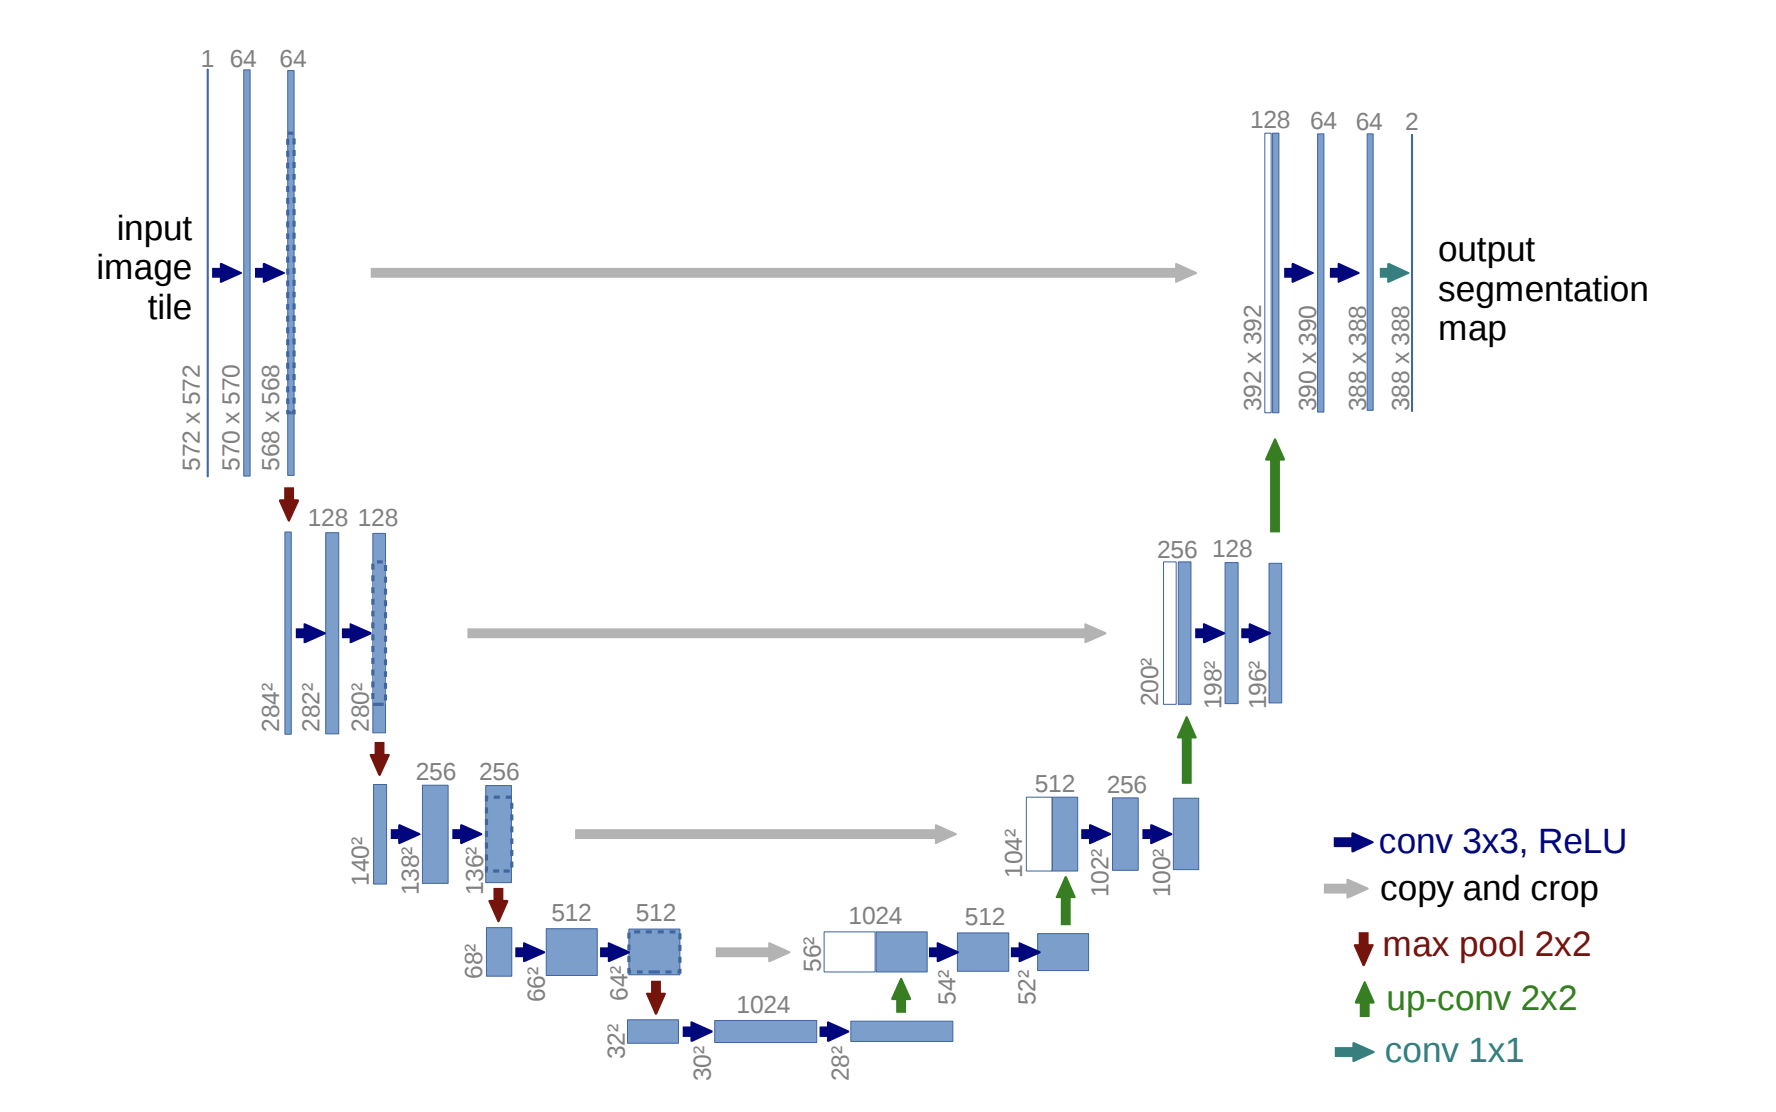

In [8]:
import torch.nn as nn
def UpDownConv(in_channels, mid_channels, out_channels):
    return nn.Sequential(
            *ConvRelu(in_channels, mid_channels, kernel_size=3, stride=1, padding=1 ),
            *ConvRelu(mid_channels, out_channels, kernel_size=3, stride=1, padding=1 ),
    )
def ConvRelu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]
class UNet(nn.Module):
    
    def __init__(self, in_shape, num_classes):
        super(UNet, self).__init__()
        in_channels, height, width = in_shape

        self.down1 = nn.Sequential(
            *ConvRelu(in_channels, 16, kernel_size=3, stride=1, padding=1 ),
            *ConvRelu(16, 32, kernel_size=3, stride=2, padding=1 ),
        )
        #64
        self.down2 = UpDownConv(32, 64, 128)
        #32
        self.down3 = UpDownConv(128, 256, 512)
        #16
        self.down4 = UpDownConv(512, 512, 512)
        #8
        self.same = nn.Sequential(
            *ConvRelu(512,512, kernel_size=1, stride=1, padding=0 ),
        )
        #16
        self.up4 = UpDownConv(1024, 512, 512)
        #16
        self.up3 = UpDownConv(1024, 512, 128)
        #32
        self.up2 = UpDownConv(256, 128, 32)
        #64
        self.up1 = UpDownConv(64, 64, 32)
        #128

        self.up0 = nn.Sequential(
            *ConvRelu(32, 32, kernel_size=3, stride=1, padding=1 ),
        )
        #256

        self.classify = nn.Conv2d(32, num_classes, kernel_size=1, stride=1, padding=0 )

    def forward(self, x):

        down1 = self.down1(x)
        out   = F.max_pool2d(down1, kernel_size=2, stride=2) #64
        down2 = self.down2(out)
        out   = F.max_pool2d(down2, kernel_size=2, stride=2) #32
        down3 = self.down3(out)
        out   = F.max_pool2d(down3, kernel_size=2, stride=2) #16
        down4 = self.down4(out)
        out   = F.max_pool2d(down4, kernel_size=2, stride=2) # 8
        out   = self.same(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #16
        out   = torch.cat([down4, out],1)
        out   = self.up4(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #32
        out   = torch.cat([down3, out],1)
        out   = self.up3(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #64
        out   = torch.cat([down2, out],1)
        out   = self.up2(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #128
        out   = torch.cat([down1, out],1)
        out   = self.up1(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #256
        out   = self.up0(out)
        out   = self.classify(out)
        return out
    

In [9]:
num_classes = 1
batch_size  = 8
C = 3
from torch.autograd import Variable
import torch.nn.functional as F

inputs = torch.randn(batch_size,C,HIGHT,WIDTH)
labels = torch.LongTensor(batch_size,HIGHT,WIDTH).random_(1).type(torch.FloatTensor)

net = UNet(in_shape=(C,HIGHT,WIDTH), num_classes=1).train().cuda()
x = Variable(inputs).cuda()
y = Variable(labels).cuda()
logits = net.forward(x)

probs = F.sigmoid(logits)
probs_flat = probs.view (-1)
targets_flat = y.view(-1)
loss = nn.BCELoss().cuda()
output = loss(probs_flat, targets_flat)
output.backward()

print(type(net))
print(net)

<class '__main__.UNet'>
UNet(
  (down1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
  )
  (down2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(256, 512

In [ ]:
output

### Soft Dice Loss implementation:

In [10]:
class DiceLoss(nn.Module):
    def __init__(self): 
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.
        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()

        return 1 - ((2. * intersection + smooth) /
                    (iflat.sum() + tflat.sum() + smooth))

## Validation function

In [11]:
net = UNet(in_shape=(C,HIGHT,WIDTH), num_classes=1).cuda()
net.load_state_dict(torch.load(DATA_DIR +'/checkpoint/model.pth'))
    
validation_dataset = ImageMaskDataset(
                            ids_test, mode='train',
                            transform = simple_augment)
    
    
validation_loader  = DataLoader(
                        validation_dataset,
                        sampler = RandomSampler(validation_dataset),
                        batch_size  = 16,
                        drop_last   = True,
                        num_workers = 8)

In [22]:
def validation_loss(net, loader, loss_type):
    validation_loader = loader
    net.eval()
    totall_val_loss = 0
    val_batch_num = 0
    for val_index, val_data in enumerate(validation_loader):
        val_image, val_mask = val_data
        if cuda:
            val_tensors = Variable(val_image).cuda()
            val_masks   = Variable(val_mask).cuda()
        else:
            val_tensors = Variable(val_image)
            val_masks   = Variable(val_mask)
        val_logits  = net(val_tensors.float())
        if loss_type == "BCE":
            val_loss = nn.BCELoss()
            val_probs   = F.sigmoid(val_logits)
            val_probs_flat = val_probs.view(-1)
            val_masks_flat = val_masks.view(-1)
        elif loss_type == "DICE":
            val_loss = DiceLoss()
            val_probs   = F.sigmoid(val_logits)
            val_probs_flat = val_probs.view(-1)
            val_masks_flat = val_masks.view(-1)
            
        elif loss_type == "NLLL":
            val_loss = nn.CrossEntropyLoss()
            val_probs = F.log_softmax(val_logits)
            val_probs_flat = val_probs
            val_masks_flat = val_masks
            
        if cuda:
            val_loss = val_loss.cuda()
        output = val_loss(val_probs_flat, val_masks_flat.float())
        totall_val_loss += output.data[0]
        val_batch_num += 1
    net.train()
    print('\r validation loss:  %f' % (totall_val_loss/val_batch_num))
    return totall_val_loss/val_batch_num

### Training prodecure 

In [14]:
import torch.optim as optim
LR = 0.0002
batch_size = 32
net = UNet(in_shape=(C,HIGHT,WIDTH), num_classes=1).train()
epochs = 100
cuda = True
ADAM = True


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = LR * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
        
def train(loss_type):
    if ADAM:
        optimizer = \
                    optim.Adam(net.parameters(),
                               lr= LR, betas=(0.5, 0.999))
    else:
        optimizer = \
                    optim.SGD(filter(lambda p: p.requires_grad, net.parameters()),
                              lr=0.01/iter_accum, momentum=0.9, weight_decay=0.0001)
            
        
    train_dataset = ImageMaskDataset(
                                ids_train, mode='train',
                                transform = data_aug)
    validation_dataset = ImageMaskDataset(
                                ids_test, mode='train',
                                transform = simple_augment)
    
    train_loader  = DataLoader(
                        train_dataset,
                        sampler = RandomSampler(train_dataset),
                        batch_size  = batch_size,
                        drop_last   = True,
                        num_workers = 8)
    
    validation_loader  = DataLoader(
                        validation_dataset,
                        sampler = RandomSampler(validation_dataset),
                        batch_size  = batch_size,
                        drop_last   = True,
                        num_workers = 8)
    
    i = 0
    if cuda:
        net.cuda()
    val_losses = []
    train_losses = []
    while  i < epochs:  
        sum_train_loss = 0.0
        sum_train_acc  = 0.0
        sum = 0
        net.train()
        optimizer.zero_grad()
        j = 0
        sum_per_batch = 0
        for index, data  in enumerate(train_loader):
            j = j+1
            image,mask = data
            if cuda:
                tensors = Variable(image).cuda()
                masks   = Variable(mask).cuda()
            else:
                tensors = Variable(image)
                masks   = Variable(mask)
            logits  = net(tensors.float())
            if loss_type == "BCE":
                probs   = F.sigmoid(logits)
                loss = nn.BCELoss()
                probs_flat = probs.view(-1)
                masks_flat = masks.view(-1)
            elif loss_type == "DICE":
                probs   = F.sigmoid(logits)
                loss = DiceLoss()
                probs_flat = probs.view(-1)
                masks_flat = masks.view(-1)
            elif loss_type == "NLLL":
                probs = F.log_softmax(logits)
                loss = nn.CrossEntropyLoss()
                probs_flat = probs
                masks_flat = masks
            if cuda:
                loss = loss.cuda()
                
            output = loss(probs_flat, masks_flat.float())
            output.backward()
            optimizer.step()
            optimizer.zero_grad()
            adjust_learning_rate(optimizer, i)
            batch_loss = output.data[0]
            sum_per_batch += batch_loss
                
            for param_group in optimizer.param_groups:
                current_lr = param_group['lr']
            print('\r epoch: %d| LR: %f|batch_loss:  %f  sum_train_loss: %f'% \
                      (i, current_lr, batch_loss, sum_per_batch/j), end='',flush=True)
        i = i +1
        if(i%10 == 0):
            print('\r epoch: %d| LR: %f|batch_loss:  %f  sum_train_loss: %f\n'% \
                      (i, current_lr, batch_loss, sum_per_batch/j), end='',flush=True)
            val_losses.append(validation_loss(net, validation_loader, loss_type))
            train_losses.append(sum_per_batch/j)
            images = tensors.data.cpu().numpy()
            masks  = masks.data.cpu().numpy()
            probs  = probs.data.cpu().numpy()
            image = images[0].transpose((1,2,0))*255
            mask  = (masks[0]*255).astype(np.uint8)
            prob  = np.squeeze((probs[0]*255).astype(np.uint8), axis=0)
            image = image.astype(np.uint8)
            plt.subplot(131)
            plt.imshow(image)
            plt.subplot(132)
            plt.imshow(mask)
            plt.subplot(133)
            plt.imshow(prob)
            plt.show()
    return train_losses, val_losses

 epoch: 10| LR: 0.000200|batch_loss:  0.377682  sum_train_loss: 0.395631
 validation loss:  0.385927


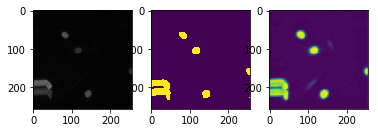

 epoch: 20| LR: 0.000200|batch_loss:  0.296466  sum_train_loss: 0.312250
 validation loss:  0.328132


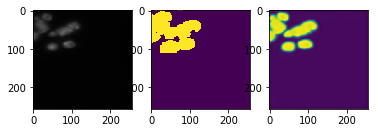

 epoch: 30| LR: 0.000200|batch_loss:  0.247044  sum_train_loss: 0.254738
 validation loss:  0.235394


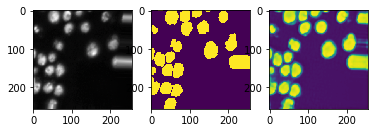

 epoch: 40| LR: 0.000020|batch_loss:  0.299443  sum_train_loss: 0.239897
 validation loss:  0.246915


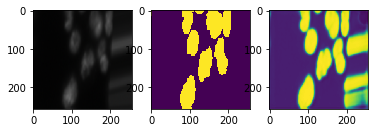

 epoch: 50| LR: 0.000020|batch_loss:  0.238577  sum_train_loss: 0.235914
 validation loss:  0.241556


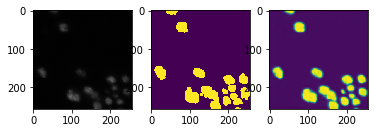

 epoch: 60| LR: 0.000020|batch_loss:  0.218292  sum_train_loss: 0.226995
 validation loss:  0.234380


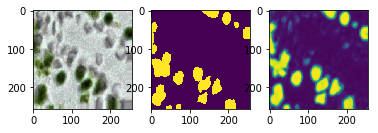

 epoch: 70| LR: 0.000002|batch_loss:  0.220308  sum_train_loss: 0.227399
 validation loss:  0.235564


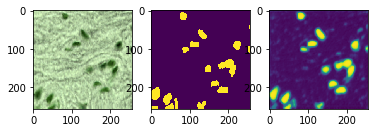

 epoch: 80| LR: 0.000002|batch_loss:  0.231606  sum_train_loss: 0.225205
 validation loss:  0.228776


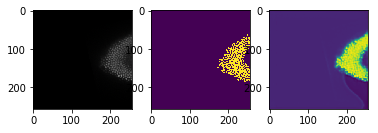

 epoch: 90| LR: 0.000002|batch_loss:  0.227427  sum_train_loss: 0.226167
 validation loss:  0.237273


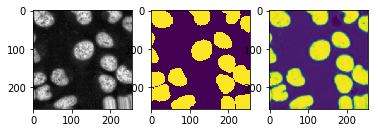

 epoch: 100| LR: 0.000000|batch_loss:  0.222470  sum_train_loss: 0.225736
 validation loss:  0.232681


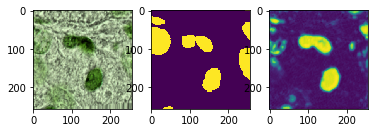

In [15]:
import warnings
warnings.filterwarnings('ignore')
train_BCE, val_BCE = train("BCE")

In [20]:
import torch 
torch.save(net.state_dict(), DATA_DIR +'/checkpoint/model_BCE.pth')

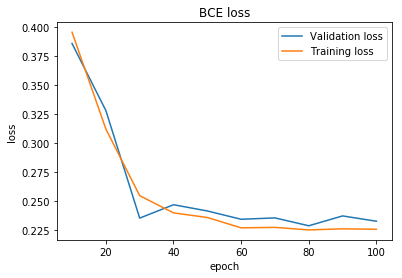

In [42]:
from matplotlib import pyplot as plt
plt.plot(list(range(10,110, 10)),val_BCE, label='Validation loss')
plt.plot(list(range(10,110, 10)),train_BCE, label='Training loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('BCE loss')
plt.legend()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
train_DICE, val_DICE = train("DICE")

In [ ]:
import torch 
torch.save(net.state_dict(), DATA_DIR +'/checkpoint/model_DICE.pth')

## Validation part

In [ ]:
validation_loss(net, validation_loader)